In [18]:
import sys
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:


california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# LinearRegression class with MSE as the error function

from modules.LinearRegression import LinearRegression 
lr_mse = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mse')
lr_mse.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr_mse.fit()

Epoch 1/1000, Loss: 3.2789042077639223
Epoch 101/1000, Loss: 0.5698021472265795
Epoch 201/1000, Loss: 0.5443136403965044
Epoch 301/1000, Loss: 0.5357610733884139
Epoch 401/1000, Loss: 0.5314748680746333
Epoch 501/1000, Loss: 0.5289006011648831
Epoch 601/1000, Loss: 0.5271828382607633
Epoch 701/1000, Loss: 0.5259577303343175
Epoch 801/1000, Loss: 0.5250361665938434
Epoch 901/1000, Loss: 0.5243207400734471


In [4]:
overall_loss= lr_mse.evaluate(X_test_scaled, y_test.reshape(-1, 1), loss_function='mse', pred=True)

In [5]:
# LinearRegression class with MAE as the error function
lr_mae = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mae')
lr_mae.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr_mae.fit()

Epoch 1/1000, Loss: 1.8049402364386058
Epoch 101/1000, Loss: 0.5792064179418921
Epoch 201/1000, Loss: 0.5456994164825738
Epoch 301/1000, Loss: 0.5343375680227286
Epoch 401/1000, Loss: 0.5286035032866038
Epoch 501/1000, Loss: 0.525145921689763
Epoch 601/1000, Loss: 0.5228337704757875
Epoch 701/1000, Loss: 0.5211790456209363
Epoch 801/1000, Loss: 0.5199369002278477
Epoch 901/1000, Loss: 0.5189702638372731


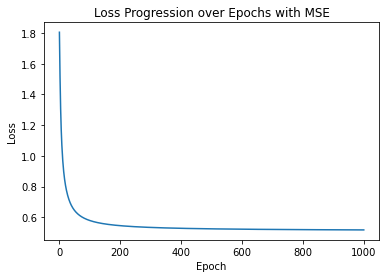

In [6]:

import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr_mse.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


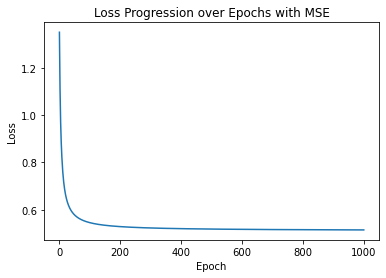

In [11]:
import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr_mae.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


In [14]:
_, y_pred_mse = lr_mse.evaluate(X_test_scaled, y_test.reshape(-1, 1), pred = True) 

In [15]:
_, y_pred_mae = lr_mae.evaluate(X_test_scaled, y_test.reshape(-1, 1), pred = True)

In [16]:
scores = pd.DataFrame.from_dict({
  'LR with MSE': lr_mse.get_r2_score(), 
  'LR with MAE': lr_mae.get_r2_score() 
}, orient='index')

display(scores)

0.5754508129873244
0.5543460402868989


,0
LR with MSE,0.575451
LR with MAE,0.554346


While the R-squared score is in the range of 0.5 - 0.75, it's moderately good. But there's still room for improvement. 

A few methodologies that can be tried out. 

1. Regularization 
2. Cross-Validation 


One thing in particular that might help is plotting residuals and observe if there's any pattern in the data that's being predicted. An observation on this might give a peek into the model's understanding of the data. 

In [35]:
import matplotlib.pyplot as plt

def plot_residuals( y, y_pred, plt_title = 'Residuals'):
    try: 
    

        y= np.asarray(y)
        y_pred = np.asarray(y_pred)
        if y.size == 0 or y_pred.size ==0:
            raise ValueError("y or y_pred input arrays cannot be empty.") 
        if y.shape != y_pred.shape:
            raise ValueError(f"y.shape : {y.shape} and y_pred.shape: {y_pred.shape} have incompatible dimensions.")

        residuals = y - y_pred
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.axhline(y=0, color='r', linestyle='--')
        
        # Add a lowess trendline
        plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)


        smooth = lowess(residuals.ravel(), y_pred.ravel())
        plt.plot(smooth[:, 0], smooth[:, 1], color='purple', lw=2)
        
        plt.show()
    except Exception as e:
        print(f"Error in computing residual plot: {str(e)}")

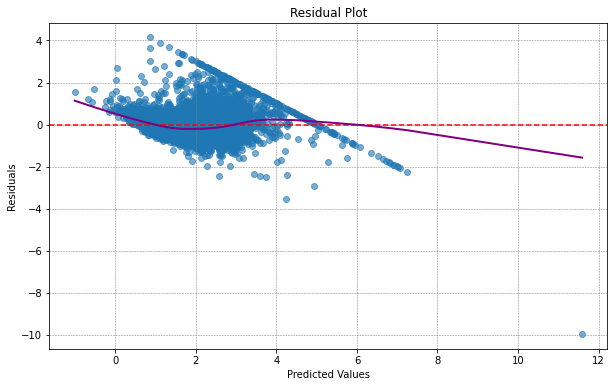

In [36]:
plot_residuals(y_test.reshape(-1, 1), y_pred_mse, plt_title='Residual Plot for LR with MSE')

**A Few Noteworthy Insights from the Residue Plot** 

1. The lowess line being curved, indicates a potential non-linear relationship in the data. Hence a linear model like Linear Regression might not be the best choice for capturing such a relationship. 

2. The model is heteroscedastic in nature, given how the variance of the residues does not seem constant across all levels.
  - This violates the basic assumption of Linear Regression on homoscedasticity. 
  - This impacts on the reliability in the predictions in the model across different ranges of the target variable.
   
3. An underlying bias in the model can be observed as the model seems to overpredict for higher values (more -ves as we move towards higher predicted values) and under predict for lower values. 

4. The curved nature of an otherwise ideal LOWESS curve ( should by co-incidental with y=0) is a clear indicator of a non-linear relationship in the data and hence, need to explore into other methods that can better capture this non-linear relationship.  